In [2]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import warnings
# import matplotlib.animation
# %matplotlib inline

### Method Set Up

Try to solve the problem using Backwards Euler. It was mentioned in lectures and workshops that this method is preferred.

The set up is the same:

In [3]:
D = 0.1 # Diffusion coefficient
v = 0.2 # Blood flow rate

Cf_desired = 1e-3 # Desired final concentrations

In [4]:
# Time parameters
Nt_gaps = 1000    # number of timesteps
T = 60             # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step
dt = t[1] - t[0]


# x parameters
Nx_spaces = 1000;   # number of spaces in x
L1 = -10; # Distance behind 0 reference point
L2 = 25 # Distance in front  0 reference point
Nx_points = Nx_spaces + 1 
x = np.linspace(L1, L2, Nx_points)    # mesh points in space
dx = x[1] - x[0]

# Check our conditions
C = D*dt/(dx**2)
A = v*dt/(2*dx)

print(f"Delta x = {round(dx, 4)}\nDelta t = {round(dt, 4)}\nC = {round(C, 4)}\nA = {round(A, 4)}")


if C >= 0.5:
    warnings.warn(f'C is greater than 0.5, C = {round(C,4)}')

if A > 1:
    warnings.warn(f'A is greater than 1, A = {round(A,4)}')

# Boundary conditions
# dirichlet
b0 = 0
bL = 0

Delta x = 0.035
Delta t = 0.06
C = 4.898
A = 0.1714


C:\Users\mattr\AppData\Local\Temp\ipykernel_26628\2984171996.py:25: UserWarning: C is greater than 0.5, C = 4.898
  warnings.warn(f'C is greater than 0.5, C = {round(C,4)}')


In [5]:
def I(x, C0): # initial u(x,0)
    u = np.zeros_like(x)
    
    # where x is between 0 and 1, set to C0
    u[(x >= 0) & (x <= 1)] = C0
    return u

# Initial concentration
C0 = 1e-2

Solve using matrices

In [9]:
# set up matrices for single time solutions and the full solution
u   = np.zeros(Nx_points)
u_old = np.zeros(Nx_points)

U = np.zeros((Nx_points,Nt_points))
U_ex = np.zeros((Nx_points, Nt_points))

# Data structures for the linear system
A_mat = np.zeros((Nx_points, Nx_points))
b = np.zeros(Nx_points)

for i in range(1, Nx_points-1):
    A_mat[i,i-1] = -C - A
    A_mat[i,i+1] = -C + A
    A_mat[i,i] = 1 + 2*C
    
# implement the (constant-in-time) Dirichlet conditions
A_mat[0,0] = 1
A_mat[Nx_points-1,Nx_points-1] = 1

# do not use the inverse method below - it is numerically unstable but is included here
# for comparison purposes.
# Find the inverse of A which doesn't change in time
# Ainv = np.linalg.inv(A)

# Set initial condition u(x,0) = I(x)
u_old = I(x, C0)

# initialise matrices for storing solutions
U[:,0] = u_old

# do timestepping 
for n in range(1, Nt_points):
    
    # Compute b and solve linear system
    b[1:Nx_points-2] = u_old[1: Nx_points-2]  # internal values
    b[0] = b0  # boundary conditions  
    b[-1] = bL
    
    # update u by calculating A_inverse . b - again, don't do this!
    #u_new = np.dot(Ainv,b)

    # update u by solving the matrix system Au = b
    u_new = np.linalg.solve(A_mat,b)
    
    # Update u_old before next step
    u_old = u_new
    U[:,n] = u_new


In [6]:
def concentration_x_plot(x, U, t_str, ax):
    heart_loc = 13
    index_closest = (np.abs(x - heart_loc)).argmin()
    C_heart = U[index_closest]
    # print(index_closest)

    # Clear axes for next iteration of animation loop
    # ax.clear() 
    
    ax.plot(x, U, '.')
    
    ax.set_xlabel('x')
    ax.set_ylabel('concentration')
    ax.set_title(t_str)

    ax.set_xlim([0,15])
    
    ax.axvline(x=heart_loc, color='r', linestyle='--')
    
    ax.axhline(y=C_heart, color='b', linestyle='--', label= f'Cf = {round(C_heart, 4)}')
    ax.text(x=12, y=C_heart, s=f'Cf = {round(C_heart, 4)}', color='b', va='bottom', ha='left')
    # ax.legend()


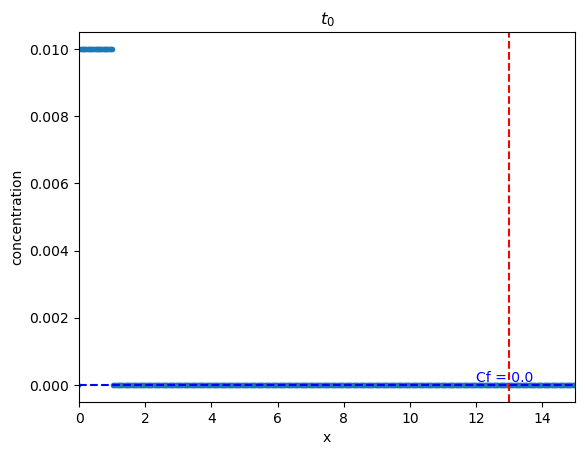

In [11]:
# Plot t = 0 (Initial condition)
fig, ax = plt.subplots()
concentration_x_plot(x, U[:,0], t_str='$t_{0}$', ax=ax)

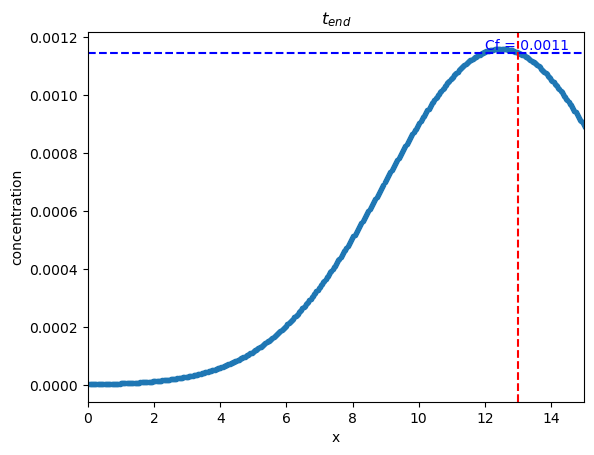

In [12]:
# Plot t = end (End of simulation)
fig, ax = plt.subplots()
concentration_x_plot(x, U[:,-1], t_str='$t_{end}$', ax=ax)

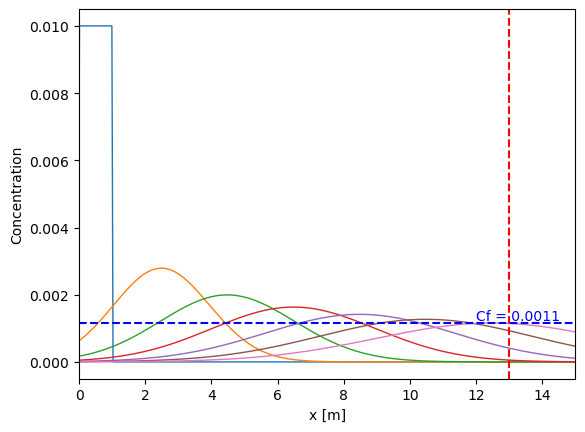

In [13]:
delta_t = 10
t_to_plot = np.arange(0, 60 + delta_t, delta_t)

heart_loc = 13
index_closest = (np.abs(x - heart_loc)).argmin()
C_heart = U[index_closest,-1]


fig, ax = plt.subplots()
for tt in t_to_plot:
    index_closest = (np.abs(t - tt)).argmin()
    ax.plot(x, U[:, index_closest], '-', linewidth = 1)
    
    if tt == 60:
        ax.axhline(y=C_heart, color='b', linestyle='--', label= f'Cf = {round(C_heart, 4)}')
        ax.text(x=12, y=C_heart, s=f'Cf = {round(C_heart, 4)}', color='b', va='bottom', ha='left')
    
ax.set_xlabel('x [m]')
ax.set_ylabel('Concentration')
ax.set_xlim([0,15])

ax.axvline(x=heart_loc, color='r', linestyle='--')

plt.show()

In [14]:
# Do this in case it happened to not go through x = 13 exactly
index_closest = (np.abs(x - 13)).argmin()

Cf = U[index_closest, -1]

print(f'Cf = {Cf}')

Cf = 0.001145896777205418


We can note that the solution is nearly identical to the forward euler using a significantly larger step size, however the time to compute increases dramatically (the inefficiencies using np.linalg.solve).

There is probably some optimization that can be done to choose a proper parameter size for Backward Euler which is stable, efficient time-wise, and has a large step size.

Try using the function

In [12]:
from functions import backward_euler as be

Nt_gaps = 1000    # number of timesteps
T = 60             # final time 

Nx_spaces = 500;   # number of spaces in x
L1 = -10; # Distance behind 0 reference point
L2 = 25 # Distance in front  0 reference point

Cf, U, x, t = be(Nt_gaps, Nx_spaces, L1, L2, C0, T=60, D=0.1, v=0.2, b0=0, bL=0, x_heart=13)

Delta x = 0.07
Delta t = 0.06
C = 1.2245
A = 0.0857


c:\uoe_repos\ind-maths-project-1-group-10\functions.py:100: UserWarning: C is greater than 0.5, C = 1.2245
  warnings.warn(f'C is greater than 0.5, C = {round(C,4)}')


In [13]:
Cf

0.0011832849113344772